In [1]:
import sys
from pathlib import Path

import random

import numpy as np

import re

import pandas as pd
from tqdm import tqdm


import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import scipy.stats

import krippendorff


random.seed(675756)
np.random.seed(675756)

base_path = Path("/home/mitarb/steen/Documents/public_repositories/summary_lq_analysis")
sys.path.append(str(base_path/"scripts"))

import summaryanalysis.ordinal as ordinal
from summaryanalysis.timereliability import compute_time_reliability_curve, compute_grouped_subsample_variance
from summaryanalysis.srh import compute_annotator_srh
from summaryanalysis.art import paired_approximate_randomization_test
from summaryanalysis.montecarlo import run_art_experiment, filter_wrong_rankings, read_obspower_files, run_art_experiment_fixed_budget, get_model_type1_error_rates


#from summaryanalysis.timereliability import compute_grouped_subsample_variance


annotations_dir = base_path / "anonymized_annotations"

data_path = annotations_dir / "judgements/"
times_path = annotations_dir / "times"
obs_power_path = base_path / "obspower"
model_path = base_path / "models"

In [2]:


experiments = {}
times = {}

for method in "rank", "likert":
    for question in "repetition", "coherence":
        fname = f"{method}_{question}_cnn_dm.csv"
        experiments[method, question] = pd.read_csv(data_path / fname, index_col=[0, 1, 2])
        times[method, question] = pd.read_csv(times_path / fname, index_col=[0, 1])["time_stamp"]

models = {
    "coherence": ordinal.OrdinalModel.from_file(model_path / "model_logit_likert_cnndm_coherence.json"),
    "repetition": ordinal.OrdinalModel.from_file(model_path / "model_logit_likert_cnndm_repetition.json")
}

#experiments["repetition", "likert"] data_path / 

In [3]:
all_mean_scores = {}
for (method, question), judgements in experiments.items():
    mean_scores = judgements.groupby("system").mean()
    if method == "rank":
        mean_scores += 1 # We export 0-based ranks, but 1-based ranks are more readable

    all_mean_scores[method, question] = mean_scores

order = [
    ("likert", "coherence"),
    ("rank", "coherence"),
    ("likert", "repetition"),
    ("rank", "repetition")
]

system_order = ["BART", "__REFERENCE__", "abssentrw", "onmt_pg", "seneca"]
    
headers = []
for (method, question) in order:
    headers.append(f"{method} - {question}")
    


    
rows = []
for system in system_order:
    row = []
    for (method, question) in order:
        mean_scores = all_mean_scores[method, question]
        row.append(f"{mean_scores.loc[system].item():.2f}")
    rows.append(row)

print("\t".join(headers))
print("\n".join(map(lambda r: "\t".join(r), rows)))

likert - coherence	rank - coherence	likert - repetition	rank - repetition
5.25	1.73	5.85	2.88
4.33	3.31	6.14	2.41
4.17	3.17	4.88	3.51
4.81	2.68	5.63	2.92
3.52	4.11	5.16	3.27


In [4]:

agreement_reliabilities = {}


for (method, question), judgements in experiments.items():
    key = "score" if method == "likert" else "rank"
    annotation_matrix = pd.pivot_table(data=judgements.reset_index(), values=key, index=["document", "system"], columns="annotator")    
    agreement = krippendorff.alpha(annotation_matrix.T.to_numpy(), level_of_measurement="ordinal")
    agreement_reliabilities[method, question] = agreement

for (method, question), score in agreement_reliabilities.items():
    print(f"{method} {question} {score:.2f}")

rank repetition 0.18
rank coherence 0.43
likert repetition 0.27
likert coherence 0.22


In [5]:

for (method, question), judgements in experiments.items():
    key = "score" if method == "likert" else "rank"
    srh = compute_annotator_srh(judgements, score_names=[key])
    srh = srh["pearson"].get(key)
    print(method, question, f"{srh:.2f}")

rank repetition 0.91
rank coherence 0.98
likert repetition 0.95
likert coherence 0.96


In [6]:
%matplotlib notebook


def create_time_buckets(times):
    times = np.array(times)
    out_times = np.zeros(shape=len(times))
    
    times /= 60.
    
    return np.floor(times / 10.) * 10.

reliabilities = {}
for method, question in sorted(experiments, reverse=False):
    reliabilities[method, question] = compute_time_reliability_curve(experiments[method, question], times[method, question], score_key="score" if method != "rank" else "rank")

100%|██████████| 190/190 [00:00<00:00, 613.96it/s]


likert coherence
likert repetition
rank coherence
rank repetition



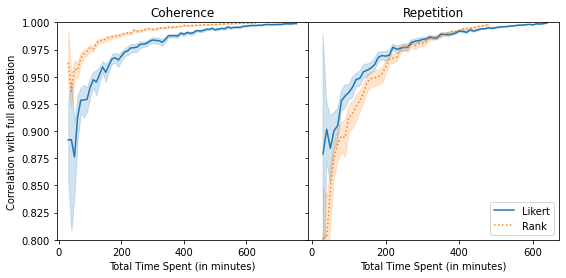

In [7]:
%matplotlib inline
#sns.lineplot(create_time_buckets(times["rank", "coherence"]), experiments["rank", "coherence"], dashes=[(2,2)])

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

plt.sca(ax1)

ax1.title.set_text("Coherence")
ax2.title.set_text("Repetition")

ax1.set_ylim(0.8, 1)
ax2.set_ylim(0.8, 1)

fig = plt.gcf()
fig.set_size_inches(9, 4)

fig.subplots_adjust(wspace=0)

ax1.set_ylabel('Correlation with full annotation')
ax1.set_xticks([0, 200, 400, 600])
ax2.set_xticks([0, 200, 400, 600])
ax1.set_xlabel('Total Time Spent (in minutes)')
ax2.set_xlabel('Total Time Spent (in minutes)')


for method, question in sorted(experiments, reverse=False):
    if question == "coherence":
        ax = ax1
        label = None
    else:
        ax = ax2
        label = "Likert" if method == "likert" else "Rank"
    plt.sca(ax)
    print(method, question)
    correlations, corr_times = reliabilities[method, question]
    sns.lineplot(x=create_time_buckets(corr_times), y=correlations, label=label)
    
    if method == "rank":
        ax.lines[-1].set_linestyle(":")

plt.legend(loc="lower right")


fig.savefig('timespower-new.png', dpi=100, bbox_inches='tight')

print()



Compute the score distribution

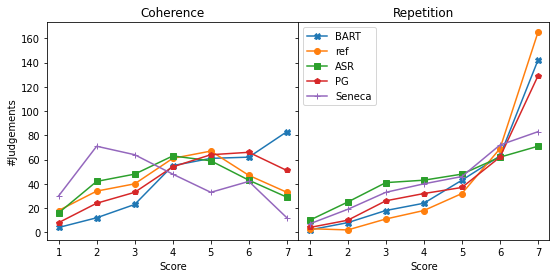

In [8]:
_, axes = plt.subplots(1, 2, sharey=True)

markers = {
    "BART": "X",
    "__REFERENCE__": "o",
    "seneca": "+",
    "abssentrw": "s",
    "onmt_pg": "p"
}

labels = {
    "BART": "BART",
    "__REFERENCE__": "ref",
    "seneca": "Seneca",
    "abssentrw": "ASR",
    "onmt_pg": "PG"
}

likert_experiments = list(filter(lambda x: x[0][0] == "likert", sorted(experiments.items())))

for idx, (ax, ((method, question), annotations)) in enumerate(zip(axes, likert_experiments)):
    all_val_counts = annotations.groupby(["system", "score"]).size()
    
    systems = sorted(all_val_counts.index.unique("system"))
    for system in systems:
        val_counts = all_val_counts.xs(system, level="system")
        ax.plot(val_counts.index.to_frame()["score"], val_counts, marker=markers[system], label=labels[system])
    
    if idx == 1:
        ax.set_title("Repetition")
        plt.legend()
    else:
        ax.set_ylabel("#Judgements")
        ax.set_title("Coherence")
    ax.set_xlabel("Score")
        
fig = plt.gcf()
fig.subplots_adjust(hspace=0, wspace=0)
fig.set_size_inches(9, 4)
fig.savefig('scoredist.png', dpi=100, bbox_inches="tight")

In [ ]:
blocks = [(1, 100), (2, 50), (4, 25), (5, 20), (10, 10), (20, 5), (50, 2), (100, 1)]
error_rates = {}

for question, model in models.items():
    error_rates[question] = get_model_type1_error_rates(model, blocks)

 30%|███       | 303/1000 [03:43<08:34,  1.35it/s]


 36%|███▋      | 364/1000 [04:28<07:49,  1.35it/s]

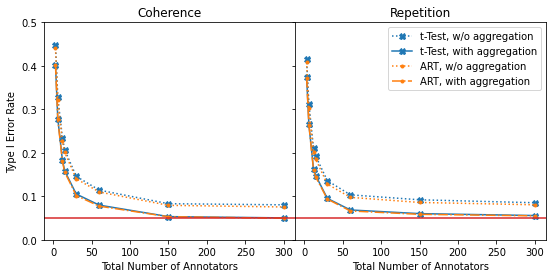

In [20]:
def plot_error_rates(error_rates, ax, idx):
    ax.plot([block_count * 3 for block_count, doc_count in blocks], error_rates['ttest_no_agg'], ":X", color="tab:blue", label="t-Test, w/o aggregation")
    ax.plot([block_count * 3 for block_count, doc_count in blocks], error_rates['ttest_agg'], "-X", color="tab:blue", label="t-Test, with aggregation")

    ax.plot([block_count * 3 for block_count, doc_count in blocks], error_rates['art_no_agg'], ":.", color="tab:orange", label="ART, w/o aggregation")
    ax.plot([block_count * 3 for block_count, doc_count in blocks], error_rates['art_agg'], "-.", marker=".", color="tab:orange", label="ART, with aggregation")

    ax.axhline(0.05, color="tab:red")

    ax.set_xlabel("Total Number of Annotators")
    
    
    if idx == 0:
        ax.set_ylabel("Type I Error Rate")

    ax.set_ylim(0, 0.5)
    
    if idx == 1:
        ax.legend()
        
    if idx == 0:
        ax.set_title("Coherence")
    else:
        ax.set_title("Repetition")

    
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

plot_error_rates(error_rates["coherence"], ax1, 0)
plot_error_rates(error_rates["repetition"], ax2, 1)

fig = plt.gcf()
fig.set_size_inches(9, 4)

fig.subplots_adjust(wspace=0)

fig.savefig('error_rates_new.png', dpi=100, bbox_inches="tight")

In [6]:
power_results = {}
power_results["regression", "coherence"] = read_obspower_files(obs_power_path, "model_logit_likert_cnndm_coherence*_5_*.csv")
power_results["regression", "repetition"] = read_obspower_files(obs_power_path, "model_logit_likert_cnndm_repetition*_5_*.csv")

for question, model in models.items():
    power_results["art_agg", question] = run_art_experiment(models[question], 3, (1, 5, 10, 15, 20))
    
filtered_power_results = {}

for (test, question), df in power_results.items():
    new_df = filter_wrong_rankings(models[question], df)
    filtered_power_results[test, question] = new_df
    
#power_results["art_agg", "repetition"] = run_art_experiment(model_likerts_rep, 3, (1, 5, 10, 15, 20))

#art_power_df_likertd_raw = run_art_experiment(model_likertd, 3, (1, 5, 10, 15, 20))

In [7]:
#def filter_wrong_rankings(model, df):
#    coefficients = dict(zip(model.systems, model.coefficients))
#    correct_rankings = set((x, y) for ((x, cx), (y, cy)) in it.product(coefficients.items(), coefficients.items()) if cx > cy)
#    mask = [t in correct_rankings for t in zip(df.index.to_frame()["better"], df.index.to_frame()["worse"])]#
#    new_df = df.copy()
#    new_df["p_value"] = new_df["p_value"].where(mask, 1.0)
#    return new_df    
    
#coefficients = {
#    "coherence": dict(zip(model_likerts.systems, model_likerts.coefficients)),
#    "repetition": dict(zip(model_likerts_rep.systems, model_likerts_rep.coefficients))
#}
#    
#    
#correct_rankings = {
#    "coherence": set((x, y) for ((x, cx), (y, cy)) in it.product(coefficients["coherence"].items(), coefficients["coherence"].items()) if cx > cy),
#    "repetition": set((x, y) for ((x, cx), (y, cy)) in it.product(coefficients["repetition"].items(), coefficients["repetition"].items()) if cx > cy)
#
#}



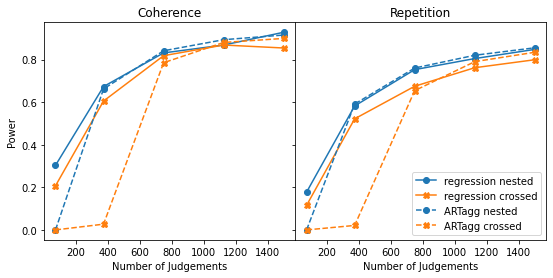

In [8]:

_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for ax, model in zip([ax1, ax2], ["coherence", "repetition"]):
    
    if model == "coherence":
        ax.set_title("Coherence")
    else:
        ax.set_title("Repetition")

    for test in "regression", "art_agg":
        test_df = filtered_power_results[test, model]
        #test_df = model_df.xs(test, level="test")

        test_df["is_sig"] = test_df["p_value"] < 0.05

        test_df = test_df.groupby(["annotators", "effort"]).mean()
                
        nested_df = test_df.xs(1, level="annotators").reset_index()
        crossed_df = test_df.xs(3, level="annotators").reset_index()
        
        style = "-" if test == "regression" else "--"
        
        if test == "art_agg":
            test_name = "ARTagg"
        else:
            test_name = "regression"
        
        ax.plot(nested_df["effort"] * 5, nested_df["is_sig"], style, color="tab:blue", marker="o", label=f"{test_name} nested")
        ax.plot(crossed_df["effort"] * 5, crossed_df["is_sig"], style, color="tab:orange", marker="X", label=f"{test_name} crossed")
        
        ax.set_xlabel("Number of Judgements")
        if model == "coherence":
            ax.set_ylabel("Power")
plt.legend()

fig = plt.gcf()
fig.subplots_adjust(hspace=0, wspace=0)

fig.set_size_inches(9, 4)
fig.savefig('power-new.png', dpi=100, bbox_inches="tight")


In [9]:
#from collections import defaultdict

#pvals = defaultdict(list)
#all_keys = []

#for n_blocks in (1, 2, 4, 5, 10, 20, 25):
#    pvals["art_agg", "coherence"].append(get_art_pvals(model_likerts, ordinal.create_design(n_blocks, 100 // n_blocks, 3)))
#    pvals["art_agg", "repetition"].append(get_art_pvals(model_likerts_rep, ordinal.create_design(n_blocks, 100 // n_blocks, 3)))
#    
#    all_keys.append((n_blocks, 100 * 3, n_blocks * 3))
    

#pval_dfs = {}

#for key, vals in pvals.items():
#    pval_dfs[key] = pd.concat(vals, keys=all_keys, names=["annotators", "effort", "total_annotators"])

pval_dfs = {}
for question, model in models.items():
    pval_dfs["art_agg", question] = run_art_experiment_fixed_budget(model, 100, 3, (1, 2, 4, 5, 10, 20, 25))



filter_func = lambda name, b, d, a: b * d == 100
pval_dfs["regression", "coherence"] = read_obspower_files(obs_power_path, "model_logit_likert_cnndm_coherence*_*_3.csv", filter_func=filter_func)
pval_dfs["regression", "repetition"] = read_obspower_files(obs_power_path, "model_logit_likert_cnndm_repetition*_*_3.csv", filter_func=filter_func)

filtered_pval_dfs = {}

for (test, question), df in pval_dfs.items():
    new_df = filter_wrong_rankings(models[question], df)
    if test == "arg_agg":
        test = "art_agg"
    filtered_pval_dfs[test, question] = new_df

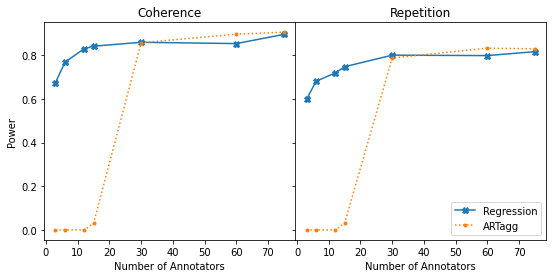

In [10]:


_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for ax, question in zip((ax1, ax2), ("coherence", "repetition")):
#    color = "tab:blue"
#    if model == "Likert":
#        color = "tab:orange"
    regression_df = filtered_pval_dfs["regression", question]
    art_df = filtered_pval_dfs["art_agg", question]
    
    regression_sig = (regression_df["p_value"] < 0.05).groupby(["total_annotators"]).mean()
    art_sig = (art_df["p_value"] < 0.05).groupby(["total_annotators"]).mean()

    ax.plot(
        regression_sig.reset_index()["total_annotators"],
        regression_sig,
        "-X",
        label=f"Regression"
    )
    ax.plot(
        art_sig.reset_index()["total_annotators"],
        art_sig,
        ":.",
        label=f"ARTagg",
        
    )
    
    ax.set_xlabel("Number of Annotators")
        
    if question == "coherence":
        ax.set_ylabel("Power")
        ax.set_title("Coherence")
    else:
        ax.set_title("Repetition")


plt.legend()

fig = plt.gcf()
fig.subplots_adjust(hspace=0, wspace=0)

fig.set_size_inches(9, 4)
fig.savefig('annopower-new.png', dpi=100, bbox_inches="tight")


In [ ]:


crossed_results = {}
nested_results = {}

for (method, question), judgements in experiments.items():
    score_name = "score" if method == "likert" else "rank"
    crossed_results[method, question] = compute_grouped_subsample_variance(judgements, True, score_name=score_name)
    nested_results[method, question] = compute_grouped_subsample_variance(judgements, score_name=score_name)




  5%|▌         | 1/20 [00:12<03:52, 12.26s/it]/home/mitarb/steen/Documents/global_venvs/pytorch/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
 60%|██████    | 12/20 [02:29<01:40, 12.56s/it]

In [ ]:
%matplotlib inline
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True)

axis = [ax1, ax2, ax3, ax4]

for idx, (ax, (method, question)) in enumerate(zip(axis, [(m, q) for q in ["coherence", "repetition"] for m in ["likert", "rank"]])):
    
    sub_df_nested = nested_results[method, question]
    sub_df_nested = pd.DataFrame(zip(sub_df_nested[0], sub_df_nested[1]), columns=["cost", "pearson"])
    sub_df_crossed = crossed_results[method, question]
    sub_df_crossed = pd.DataFrame(zip(sub_df_crossed[0], sub_df_crossed[1]), columns=["cost", "pearson"])
    
    sub_df_crossed = sub_df_crossed.loc[sub_df_crossed["cost"] <= 21]
    sub_df_crossed = sub_df_crossed.loc[sub_df_crossed["cost"] >= 3]
    #sub_df_crossed = sub_df_crossed.loc[curves["cost"] <= 21]
    sub_df_nested = sub_df_nested.loc[sub_df_nested["cost"] >= 3]

    sub_df_crossed["cost"] *= 25
    sub_df_nested["cost"] *= 25
    


    ax.plot(sub_df_nested["cost"].to_numpy(), sub_df_nested["pearson"].to_numpy(), "-", marker="o", label="Nested")
    ax.plot(sub_df_crossed["cost"], sub_df_crossed["pearson"], "--", marker="X", label="Crossed")
    if idx in (0, 2):
        ax.set_ylabel("Correlation")
    if idx in (2, 3):
        ax.set_xlabel("Number of Judgements")
        
    if idx == 3:
        plt.legend(loc="lower right")
        
    fig = plt.gcf()
    fig.subplots_adjust(hspace=0, wspace=0)
    #ax.set_title(key)
    
plt.gcf().text(0.92, 0.7, "Coherence", rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.gcf().text(0.92, 0.32, "Repetition", rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.gcf().text(0.32, 0.9, "Likert", horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.gcf().text(0.71, 0.9, "Rank", horizontalalignment='center', verticalalignment='center', fontsize=12)

fig.set_size_inches(8, 8)
fig.savefig("multiannotator-new.png", bbox_inches="tight")